In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import warnings 
from sklearn.preprocessing import MinMaxScaler
import platform
import squarify
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/df_cleaned.csv' ).drop('Unnamed: 0' , axis = 1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34


In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392857 entries, 0 to 392856
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         392857 non-null  object        
 1   StockCode         392857 non-null  object        
 2   Description       392857 non-null  object        
 3   Quantity          392857 non-null  int64         
 4   InvoiceDate       392857 non-null  datetime64[ns]
 5   UnitPrice         392857 non-null  float64       
 6   CustomerID        392857 non-null  float64       
 7   Country           392857 non-null  object        
 8   QuantityCanceled  392857 non-null  int64         
 9   Total_Price       392857 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 24.0+ MB


# RFM Analysis 

### Calculating the Recency score (F) 

Recency (R) as days since last purchase: How many days ago was their last purchase? Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?

the last day on this database is 10/12/2011 .

In [4]:
R_df = df[['InvoiceDate' , 'CustomerID']].copy()
R_df = R_df.groupby('CustomerID').max()
R_df['Recency'] = (datetime.datetime(2011 , 12 ,10) - R_df['InvoiceDate']).map(lambda x : x.days)

### Calculating the Frequency score (F)

Frequency (F) as total number of transactions: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.

In [5]:
df['frequency'] = 1
R_df['frequency'] = df[['CustomerID' ,'frequency']].groupby('CustomerID')['frequency'].sum()
R_df.head()

,InvoiceDate,Recency,frequency
CustomerID,,,
12346.0,2011-01-18 10:01:00,325,1
12347.0,2011-12-07 15:52:00,2,182
12348.0,2011-09-25 13:13:00,75,31
12349.0,2011-11-21 09:51:00,18,73
12350.0,2011-02-02 16:01:00,310,17


### Calculating the Monetary value score (M)

Monetary (M) as total money spent: How many $$ (or whatever is your currency of calculation) has this customer spent? Again limit to last two years – or take all time. Simply total up the money from all transactions to get the M value.

In [6]:
R_df['Monetary'] = df[['CustomerID' , 'Total_Price' ]].groupby('CustomerID')['Total_Price'].sum()
R_df.drop('InvoiceDate' , axis = 1 , inplace = True)
R_df.head()

,Recency,frequency,Monetary
CustomerID,,,
12346.0,325,1,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


### Applying RFM score formula

Once we have RFM values from the purchase history, we assign a rank from one to five to recency, frequency and monetary values individually for each customer. Five is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM ranks numbers.

In [7]:

R_df['RK'] = pd.qcut(R_df['Recency'] , 5 , ['1' , '2', '3' , '4' , '5']).astype(np.object)
R_df['FK'] = pd.qcut(R_df['frequency'] , 5 , ['1' , '2', '3' , '4' , '5']).astype(np.object)
R_df['MK'] = pd.qcut(R_df['Monetary'] , 5 , ['1' , '2', '3' , '4' , '5']).astype(np.object)
R_df['RFM score'] = R_df['RK'].map(str)  + R_df['FK'].map(str)  + R_df['MK'].map(str)
R_df = R_df.reset_index()
R_df.head()

,CustomerID,Recency,frequency,Monetary,RK,FK,MK,RFM score
0,12346.0,325,1,0.00,5,1,1,511
1,12347.0,2,182,4310.00,1,5,5,155
2,12348.0,75,31,1797.24,4,3,4,434
3,12349.0,18,73,1757.55,2,4,4,244
4,12350.0,310,17,334.40,5,2,2,522


In [8]:
R_df[R_df['RFM score'] == '555']

,CustomerID,Recency,frequency,Monetary,RK,FK,MK,RFM score
123,12501.0,336,149,2089.680,5,5,5,555
566,13093.0,275,159,7756.480,5,5,5,555
1186,13952.0,217,137,3246.091,5,5,5,555
2119,15235.0,217,143,2247.510,5,5,5,555
2547,15808.0,306,195,3648.720,5,5,5,555
3765,17504.0,206,127,2711.630,5,5,5,555
4017,17850.0,372,297,4769.520,5,5,5,555
4300,18231.0,192,123,2054.670,5,5,5,555


Thus, customers who purchased recently, are frequent buyers and spend a lot are assigned score of 555 – Recency(R) – 5, Frequency(F) – 5, Monetary(M) – 5. They are your best customers. for example customers with the ID 12501 , 13093 ,  13952 are among the highest spenders.

On the other extreme are customers spending the lowest, making hardly any purchase and that too a long time ago – a score of 111. Recency(R) – 1, Frequency(F) – 1, Monetary(M) – 1.

### Visualizing the RFM model 

Understanding $5 * 5 * 5 = 50$ elements can still be tedious. So we can summarize our analysis into 11 segments to understand our customers better.

here are 11 segments that are commonly recommended. [Link](https://docs.exponea.com/docs/rfm-segmentation)


- **Champions** >>>>	Bought recently, buy often and spend the most!	

- **Loyal Customers**	>>>> Spend good money with us often.


- **Potential Loyalist** >>>>>	Recent customers, but spent a good amount and bought more than once.	


- **Recent Customers** >>>>>	Bought most recently, but not often.	


- **Promising** >>>>>	Recent shoppers, but haven’t spent much.	Create brand awareness, offer free trials


- **Customers Needing Attention** >>>>	Above average recency, frequency and monetary values. May not have bought very recently though.	


- **About To Sleep** >>>>	Below average recency, frequency and monetary values. Will lose them if not reactivated.	


- **At Risk** >>>>	Spent big money and purchased often. But long time ago. Need to bring them back!	


- **Can’t Lose Them** >>>>	Made biggest purchases, and often. But haven’t returned for a long time. Hibernating Last purchase was long back, low spenders and low number of orders.	


- **Lost** >>>>	Lowest recency, frequency and monetary scores.	


In [9]:
Champions = ['555', '554', '544', '545', '454', '455', '445']

Loyal=['543', '444', '435', '355', '354', '345', '344', '335']

Potential_Loyalist=['553', '551', '552', '541', '542', '533',
                    '532', '531', '452', '451', '442', '441',
                    '431', '453', '433', '432', '423', '353',
                    '352', '351', '342', '341', '333', '323']

Recent_Customers=['512', '511', '422', '421','412', '411', '311']

Promising=['525', '524', '523', '522', '521',
           '515', '514', '513', '425','424', 
           '413','414','415', '315', '314',
           '313']

Need_Attention=['535', '534', '443', '434', '343', '334', '325', '324']

About_To_Sleep=['331', '321', '312', '221', '213', '231', '241', '251']

At_Risk=['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225',
         '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124']

Cannot_Lose_Them=['155', '154', '144', '214','215','115', '114', '113']

Hibernating_customers=['332','322',  '233', '232', '223', '222', '132', '123', '122', '212', '211']

Lost_customers=['111', '112', '121', '131','141','151']

R_df['Customer_segments'] = '1'


R_df['Customer_segments'][R_df['RFM score'].isin(Champions)] = 'Champions'
R_df['Customer_segments'][R_df['RFM score'].isin(Loyal)] = 'Loyal'
R_df['Customer_segments'][R_df['RFM score'].isin(Lost_customers)] = 'Lost'
R_df['Customer_segments'][R_df['RFM score'].isin(Hibernating_customers)] = 'Hibernating_customers'
R_df['Customer_segments'][R_df['RFM score'].isin(Cannot_Lose_Them)] = 'Cannot_Lose_Them'
R_df['Customer_segments'][R_df['RFM score'].isin(At_Risk)] = 'At_Risk'
R_df['Customer_segments'][R_df['RFM score'].isin(About_To_Sleep)] = 'About_To_Sleep'
R_df['Customer_segments'][R_df['RFM score'].isin(Need_Attention)] = 'Need_Attention'
R_df['Customer_segments'][R_df['RFM score'].isin(Promising)] = 'Promising'
R_df['Customer_segments'][R_df['RFM score'].isin(Recent_Customers)] = 'Recent_Customers'
R_df['Customer_segments'][R_df['RFM score'].isin(Potential_Loyalist)] = 'Potential_Loyalist'





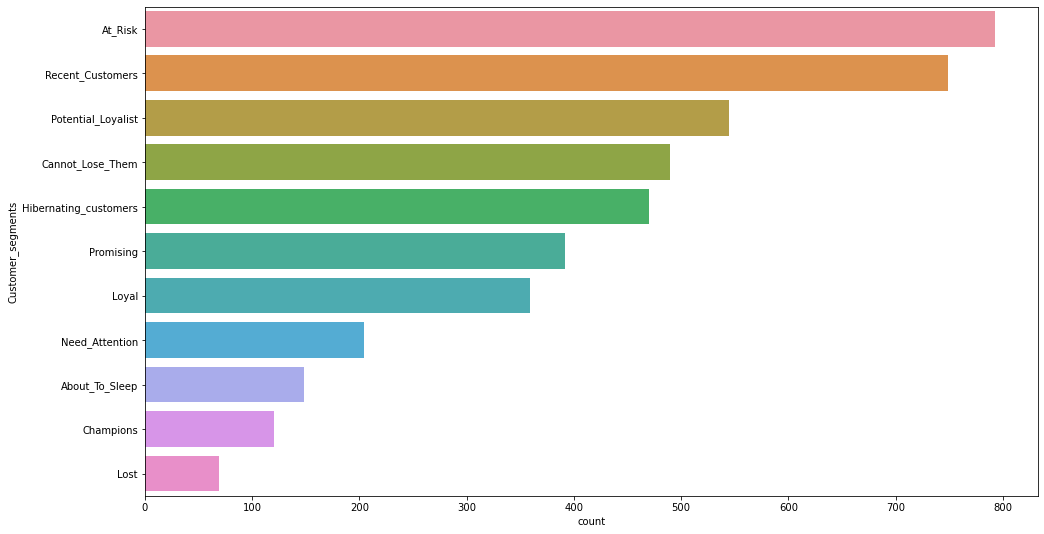

In [10]:
fig , ax = plt.subplots(1 ,1 , figsize=(16 , 9))
sns.countplot(y = R_df['Customer_segments'] , 
              order = R_df['Customer_segments'].value_counts().index , 
                 ax = ax)
plt.show()

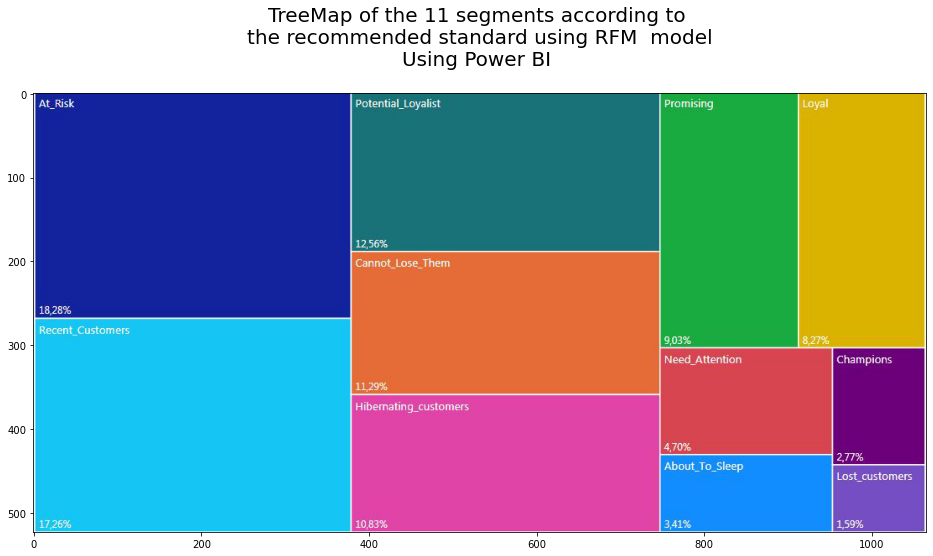

In [11]:
plt.figure(figsize = (16,10))
x = plt.imread('data/Capture.JPG')
plt.imshow(x)
plt.title('TreeMap of the 11 segments according to \nthe recommended standard using RFM  model\nUsing Power BI \n',
          fontsize=20)
plt.show()

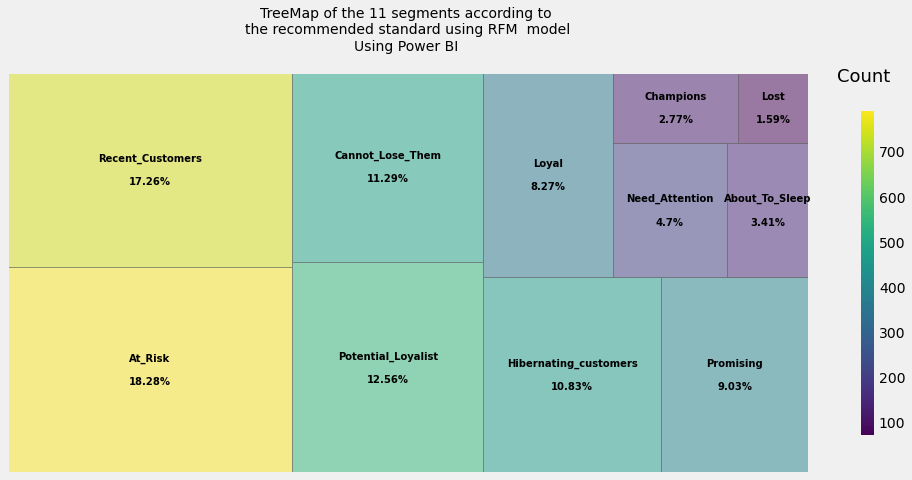

In [69]:


# treemap parameters
x = 0.
y = 0.
width = 1250.
height = 250.
cmap = cm.viridis
seg = R_df['Customer_segments'].value_counts()

# make colors 

mini, maxi = seg.min(), seg.max()
norm = mpl.colors.Normalize(vmin=mini, vmax=maxi )
colors = [cmap(norm(value)) for value in seg.values]
# colors[1] = "#FBFCFE"

# make labels 

labels = [f"{label[0]}\n\n{round((label[1]/seg.sum() ) * 100 , 2)}%" for label in zip(seg.index , seg.values)]

# make plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(seg.values, color=colors,
                   label=labels, ax=ax, alpha=.5 , norm_x=200 ,
                   text_kwargs={'fontsize':10,'weight':'bold'}) 


ax.set_xticks([])
ax.set_yticks([])
ax.set_title('TreeMap of the 11 segments according to \nthe recommended standard using RFM  model\nUsing Power BI \n'
             , fontsize=14)


fig.colorbar(img, orientation="vertical", shrink=.56)
fig.text(.80, .74, "Count", fontsize=18)



plt.show()

As we can see a huge percentage of the customers are at risk or recent ones , for those who are at risk we can try and send personalized emails to reconnect, offer renewals, provide helpful resources.

for the recent ones we can provide on-boarding support, give them early success, start building relationship.

But for the few Lost ones we can only revive interest with reach out campaign or otherwise ignore .

we should also Reward the champions that can be early adopters for new products and will promote your brand. and for loyals and potential loyalist we should upsell higher value products, Ask for reviews and Engage with them , also offer membership / loyalty program , recommend other products..



# Segmenting RFM model using unsupervised ML techniques

In [24]:
rfm = R_df[['Recency' , 'Monetary' , 'frequency']].copy()
rfm.head()

,Recency,Monetary,frequency
0,325,0.00,1
1,2,4310.00,182
2,75,1797.24,31
3,18,1757.55,73
4,310,334.40,17


In [45]:
scale = MinMaxScaler()
rfm_scaled = scale.fit_transform(rfm)
rfm_scaled

array([[8.71313673e-01, 0.00000000e+00, 0.00000000e+00],
       [5.36193029e-03, 1.54881636e-02, 2.35830619e-02],
       [2.01072386e-01, 6.45845640e-03, 3.90879479e-03],
       ...,
       [1.87667560e-02, 6.34619416e-04, 1.43322476e-03],
       [8.04289544e-03, 7.35069680e-03, 9.38110749e-02],
       [1.12600536e-01, 6.60234180e-03, 8.99022801e-03]])

In [46]:

for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(rfm_scaled)
    clusters = kmeans.predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.6544101501744964
For n_clusters = 4 The average silhouette_score is : 0.5775887474677338
For n_clusters = 5 The average silhouette_score is : 0.5701155529634565
For n_clusters = 6 The average silhouette_score is : 0.5823160169843751
For n_clusters = 7 The average silhouette_score is : 0.5602372990272086
For n_clusters = 8 The average silhouette_score is : 0.4915198167346607
For n_clusters = 9 The average silhouette_score is : 0.4988477536626294


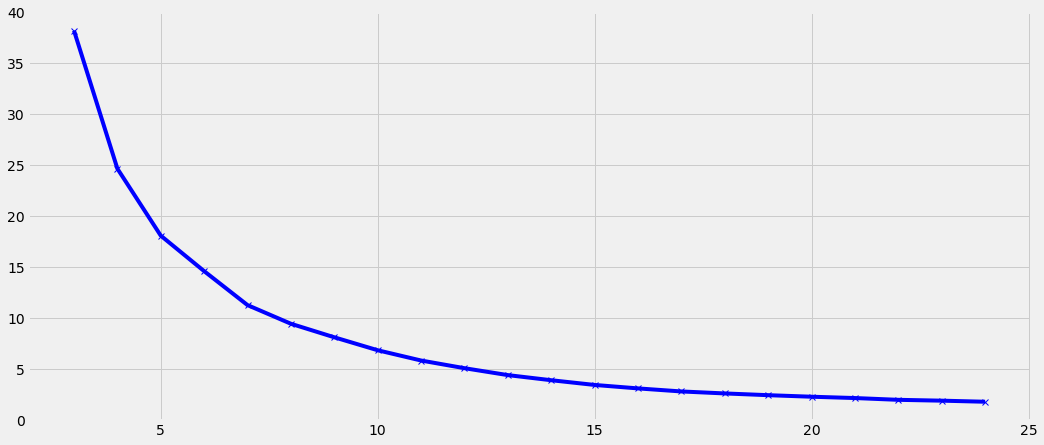

In [49]:
distortion = []
K = np.arange(3 , 25)
for n_clusters in K:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(rfm_scaled)
    distortion.append(kmeans.inertia_)
plt.figure(figsize = (16 , 7))
plt.plot(K , distortion, 'bx-' )

In [59]:
kmeans = KMeans(init='k-means++', n_clusters =11, n_init=30)
kmeans.fit(rfm)
clusters = kmeans.predict(rfm)

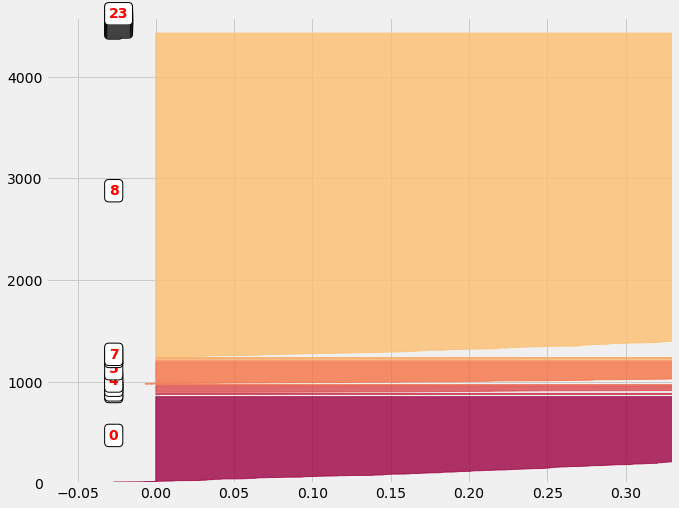

In [58]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(rfm, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(rfm), sample_silhouette_values, clusters)


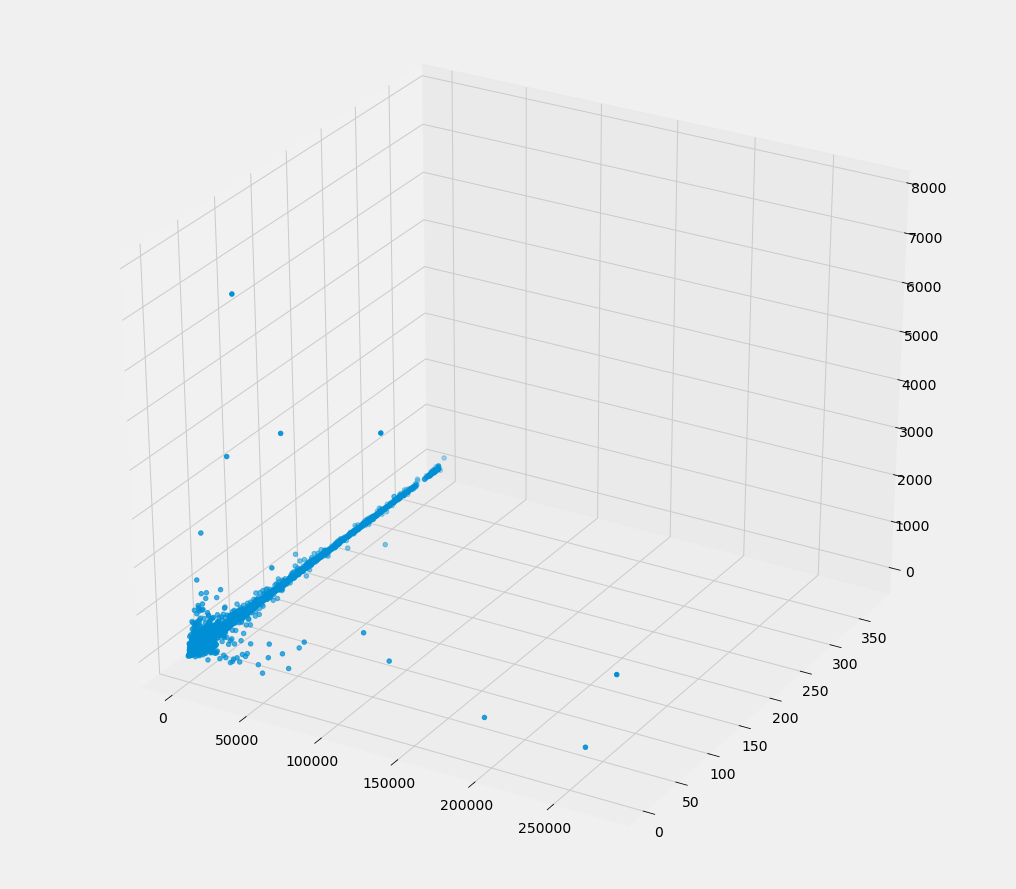

In [61]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize= (16 , 15))
# ax = fig.add_subplot(111 , projection = '3D')
ax = fig.add_subplot(111, projection='3d')

xs = rfm.iloc[: , 0]
ys = rfm.iloc[: , 1]
zs = rfm.iloc[: , 2]
ax.scatter(ys , xs , zs )

The data forms one big cluster with some scattered datapoints with high values of frequency and monetary or both , this makes traditional machine learning algorithm produce clusters with small amount of data in it which is what we saw with the silhouette graph , that leaves us with the recommended 11 segment techniques as the one that is reliable and we can make some solid decisions on it  